```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# MPI Skeleton for basic particle filter with SIR




## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import animation, rc

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

In [2]:
import ipyparallel

# attach to a running cluster
cluster = ipyparallel.Client()#profile='mpi')

print('profile:', cluster.profile)
print('Number of ids:', len(cluster.ids))
print("IDs:", cluster.ids) # Print process id numbers

profile: default
Number of ids: 4
IDs: [0, 1, 2, 3]


In [3]:
%%px 

%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from mpi4py import MPI
import gc, os, sys

#Import our simulator
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from SWESimulators import CDKLM16, Common, GPUDrifterCollection, IPythonMagic

In [4]:
%%px 

comm = MPI.COMM_WORLD

print("Hello! I'm rank %d from %d running in total..." % (comm.rank, comm.size))

#Make results deterministic
np.random.seed(seed=(42 + comm.rank))
comm.Barrier()   

[stdout:0] Hello! I'm rank 0 from 4 running in total...
[stdout:1] Hello! I'm rank 1 from 4 running in total...
[stdout:2] Hello! I'm rank 2 from 4 running in total...
[stdout:3] Hello! I'm rank 3 from 4 running in total...


In [5]:
%%px

%cuda_context_handler gpu_ctx

# Ensemble

Some basic assumptions and notes on what has to be redesigned in the future:


### Local vs global ensemble
The local ensemble is the ensemble owned by one process. The global ensemble is the combined ensemble from all processes. Only the "master" (rank 0) will care about the global ensemble in this skeleton.

### Code sections requiring MPI is clearly marked
Clearly marked with 
```
# MPI START -----------------------------
if self.rank == 0:
    ...
# MPI END -----------------------------

```
The keyword `pass` is used where there currently would be an empty block (or just a comment), so that it is valid python code.

### Initial states

The ensemble is initialized based on one simulator instance, and the ocean state in this simulator instance is completely random. The initialization method therefore requires some exchange of data so that all MPI proccesses has the same initial data to create a "local" ensemble from. 

My suggestion is that rank 0 will share its initialization input (eta, hu, hv) with the other proccesses before entering the loop that creates the ensemble members. 

**In the future** we will start the ensemble based on predefined set of initial states (e.g. large ensemble created from a small ensemble of ROMS models), and therefore the initialization will need to be different in the future.


### Initialization of the ensemble
This has been a mess in the class OceanStateEnsemble class. In the below skeleton I've tried to clean up this, so that the standard constructor is the only required function.

I've removed the option to choose between different observation operators, etc. This can be re-introduced later.

### Short cuts where there should have been some more options
We assume 
* Direct observation of underlying flow at drifter positions only
* CDKLM simulator only
* periodic boundary conditions only
* Total num particles **MUST** be a multiple of number of MPI processes (in the below version)


### Syntethic truth
The truth should only be a model realization in the master process. Currently all processes has a truth model, so that as much of the old code can be reused. For all processes with rank > 0, the simulator in self.particles[self.obs_index] should never be used.


### Too much communication
Because I want to be able to copy-paste as much code as possible, this version will most likely contain too much communication (or communication of information that has already been communicated before). This can be fixed in the future, since the most important thing in short term is correctness.

### Synchronous sends only
All communication showed below assumes synchronous sends. Nothing else happens before a send/receive is complete.


### No resampling of drifter positions 
The only drifters that are used for anything are the drifters in the syntethic truth. We keep the drifters in all the particles also (in fear of breaking something), but we ignore them. There are therefore no reason to why we should resample drifter positions, and therefore we don't.  

# How to follow the code?

There are very few functions of MPIOceanEnsemble that are used from the outside.

**First of all**, it is **the constructor** of course. It uses no other functions

**Step** is used to run the ensemble forward in time.

**And then**, the functions **getGaussianWeights** and **resample** are called **via the function DataAssimilationUtilities.residualSampling** function.

**plotDistanceInfo** creates a figure to look at the particle weights globally

That's it.

In [6]:
%%px 

class OceanModelEnsemble:
    """
    Class which holds a set of simulators on a single node, possibly with drifters attached
    """
    
    def __init__(self, gpu_ctx, sim_args, sim_ic, num_particles,
                 drifter_positions=[],
                 observation_variance = 0.01**2, 
                 initialization_variance_factor_ocean_field = 0.0):
        """
        Constructor which creates num_particles slighly different ocean models
        based on the same initial conditions
        """
        
        self.gpu_ctx = gpu_ctx
        self.sim_args = sim_args
        self.observation_variance = observation_variance
        self.initialization_variance_factor_ocean_field = initialization_variance_factor_ocean_field
        
        
        
        
        # Build observation covariance matrix:
        if np.isscalar(self.observation_variance):
            self.observation_cov = np.eye(2)*self.observation_variance
            self.observation_cov_inverse = np.eye(2)*(1.0/self.observation_variance)
        else:
            # Assume that we have a correctly shaped matrix here
            self.observation_cov = self.observation_variance
            self.observation_cov_inverse = np.linalg.inv(self.observation_cov)
            
            
            
        # Generate ensemble members
        self.particles = [None] * num_particles
        for i in range(num_particles):
            self.particles[i] = CDKLM16.CDKLM16(self.gpu_ctx, **sim_ic, **self.sim_args)
            
            if self.initialization_variance_factor_ocean_field != 0.0:
                self.particles[i].perturbState(q0_scale=self.initialization_variance_factor_ocean_field)
            
            # Attach drifters if requested
            if (len(drifter_positions) > 0):
                drifters = GPUDrifterCollection.GPUDrifterCollection(self.gpu_ctx, len(drifter_positions),
                                                                     observation_variance=self.observation_variance,
                                                                     boundaryConditions=sim_ic['boundary_conditions'],
                                                                     domain_size_x=sim_args['nx']*sim_args['dx'], 
                                                                     domain_size_y=sim_args['ny']*sim_args['dy'])
                drifters.setDrifterPositions(drifter_positions)
                self.particles[i].attachDrifters(drifters)
            
    
    
    
    def cleanUp(self):
        for oceanState in self.particles:
            if oceanState is not None:
                oceanState.cleanUp()
    
    
    
    
    def step(self, sub_t):
        """
        Function which makes all particles step until time t.
        """
        for p in self.particles:
            self.t = p.step(sub_t)
        return self.t
    
    
    
    
    
    def getDrifterPositions(self, particle_index):
        assert(MPI.COMM_WORLD.rank == 0)
        return self.particles[particle_index].drifters.getDrifterPositions()
    
    
    
    

    def getVelocity(self, drifter_positions):
        """
        Applying the observation operator on each particle.

        Structure on the output:
        [
        particle 1:  [u_1, v_1], ... , [u_D, v_D],
        particle 2:  [u_1, v_1], ... , [u_D, v_D],
        particle Ne: [u_1, v_1], ... , [u_D, v_D]
        ]
        numpy array with dimensions (num_particles, num_drifters, 2)
        
        """
        num_particles = len(self.particles)
        num_drifters = len(drifter_positions)
        
        velocities = np.empty((num_particles, num_drifters, 2))

        # Assumes that all particles use the same bathymetry
        H = self.particles[0].downloadBathymetry()[1]
        
        for p in range(num_particles):
            # Downloading ocean state without ghost cells
            eta, hu, hv = self.particles[p].download(interior_domain_only=True)

            for d in range(num_drifters):
                id_x = np.int(np.floor(drifter_positions[d, 0]/self.sim_args['dx']))
                id_y = np.int(np.floor(drifter_positions[d, 1]/self.sim_args['dy']))

                depth = H[id_y, id_x]
                velocities[p,d,0] = hu[id_y, id_x]/(depth + eta[id_y, id_x])
                velocities[p,d,1] = hv[id_y, id_x]/(depth + eta[id_y, id_x])
                
        return velocities
        



In [7]:
%%px

# Generate simulator arguments on master node and broadcast
if (MPI.COMM_WORLD.rank == 0):
    
    #Change these parameters if needed
    nx = 40
    ny = 40
    water_depth = 10.0;
    dt = 0.05
    f = 0.05
    g = 9.81
    ensemble_size = 5
    num_drifters = 3
    

    #Standard simulator args
    sim_args = {
        'nx': nx,
        'ny': ny,

        'dx': 4.0,
        'dy': 4.0,
        'dt': dt,

        'g': g,
        'r': 0.0,
        'f': f,

        'write_netcdf': False,

        # Choose a suitable amplitude for the model error.
        # This expression does not make sense (dimensionwise), but it gives a number
        # that fits well with all the other numbers (:
        'small_scale_perturbation': True,
        'small_scale_perturbation_amplitude': 0.5*dt*f/(g*water_depth),

    }
else:
    sim_args = None
    ensemble_size = None
    num_drifters = None
    
    
#Broadcast using MPI
sim_args = MPI.COMM_WORLD.bcast(sim_args, root=0)
ensemble_size = MPI.COMM_WORLD.bcast(ensemble_size, root=0)
num_drifters = MPI.COMM_WORLD.bcast(num_drifters, root=0)
num_nodes = MPI.COMM_WORLD.size
#print("Sim args: " + str(MPI.COMM_WORLD.rank) + ": " + str(sim_args), flush=True)

In [8]:
%%px 


def generateInitialConditions(sim_args, water_depth):
    assert(MPI.COMM_WORLD.rank == 0)
    
    boundary_condition_args = {
        'north': 2,
        'south': 2,
        'east': 2,
        'west': 2
    }

    dataShape = (sim_args['ny'] + 4, sim_args['nx'] + 4)
    dataShapeHi = (sim_args['ny'] + 5, sim_args['nx'] + 5)

    H = np.ones(dataShapeHi, dtype=np.float32)*water_depth
    eta = np.zeros(dataShape, dtype=np.float32)
    hv = np.zeros(dataShape, dtype=np.float32)
    hu = np.zeros(dataShape, dtype=np.float32)
    
    #Very inefficient way of creating perturbed initial state, but works
    sim_ic = {
        'H': H,
        'eta0': eta,
        'hu0': hu,
        'hv0': hv
    }
    cuda_ctx = Common.CUDAContext()
    sim = CDKLM16.CDKLM16(cuda_ctx, **sim_args, **sim_ic)
    sim.perturbState(q0_scale=100) # Create a random initial state 
    eta, hu, hv = sim.download(interior_domain_only=False)
    H = sim.downloadBathymetry()[0]
    sim = None
    
    return eta, hu, hv, H, boundary_condition_args




#Generate initial conditions on master and broadcast to all slaves
#FIXME: This is tailored to CDKLM
if (MPI.COMM_WORLD.rank == 0):
    eta, hu, hv, H, boundary_condition_args = generateInitialConditions(sim_args, water_depth)
else:
    data_shape = (sim_args['ny'] + 4, sim_args['nx'] + 4)
    eta = np.empty(data_shape, dtype=np.float32)
    hu = np.empty(data_shape, dtype=np.float32)
    hv = np.empty(data_shape, dtype=np.float32)
    H = np.empty((data_shape[0]+1, data_shape[1]+1), dtype=np.float32)
    boundary_condition_args = None
        
#Broadcast using MPI
#FIXME: Optimize this to one transfer by packing arrays
MPI.COMM_WORLD.Bcast(eta, root=0)
MPI.COMM_WORLD.Bcast(hu, root=0)
MPI.COMM_WORLD.Bcast(hv, root=0)
MPI.COMM_WORLD.Bcast(H, root=0)
boundary_condition_args = MPI.COMM_WORLD.bcast(boundary_condition_args, root=0)


#Create the initial conditions dictionary
sim_ic = {
    'H': H,
    'eta0': eta,
    'hu0': hu,
    'hv0': hv,
    'boundary_conditions': Common.BoundaryConditions(**boundary_condition_args)
}


#print("Sim_ic" + str(MPI.COMM_WORLD.rank) + ": " + str(sim_ic), flush=True)

In [9]:
%%px


def generateDrifterPositions(nx, ny, dx, dy, num_drifters):
    assert(MPI.COMM_WORLD.rank == 0)
    
    # Define mid-points for the different drifters 
    # Decompose the domain, so that we spread the drifters as much as possible
    sub_domains_y = np.int(np.round(np.sqrt(num_drifters)))
    sub_domains_x = np.int(np.ceil(1.0*num_drifters/sub_domains_y))
    midPoints = np.empty((num_drifters, 2))
    for sub_y in range(sub_domains_y):
        for sub_x in range(sub_domains_x):
            drifter_id = sub_y*sub_domains_x + sub_x
            if drifter_id >= num_drifters:
                break
            midPoints[drifter_id, 0]  = (sub_x + 0.5)*nx*dx/sub_domains_x
            midPoints[drifter_id, 1]  = (sub_y + 0.5)*ny*dy/sub_domains_y

    return midPoints



#Initialize simulators on all nodes
#Rank 0 uses just one ensemble member, but has drifters as well
if (MPI.COMM_WORLD.rank == 0):
    num_particles = 1
    drifter_positions = generateDrifterPositions(sim_args['nx'], sim_args['ny'], sim_args['dx'], sim_args['dy'], num_drifters)
else:
    num_particles = ensemble_size
    drifter_positions = []
    
ensemble = OceanModelEnsemble(gpu_ctx, sim_args, sim_ic, num_particles, 
                            drifter_positions=drifter_positions, 
                            observation_variance=0.02**2, 
                            initialization_variance_factor_ocean_field=50)

In [10]:
%%px


def getInnovations(ensemble):
    """
    Computes the innovation (vector from ensemble member to truth)
    """
    #First, broadcast the drifter positions from "truth"
    if (MPI.COMM_WORLD.rank == 0):
        drifter_positions = ensemble.getDrifterPositions(0)
    else:
        drifter_positions = np.empty((num_drifters, 2), dtype=np.float32)
    MPI.COMM_WORLD.Bcast(drifter_positions, root=0)
    
    #Then get the velocity at the drifter positions at each ensemble member
    velocities = ensemble.getVelocity(drifter_positions)
    
    
    
    #Broadcast the truth to all nodes
    if (MPI.COMM_WORLD.rank == 0):
        truth = velocities[0]
    else:
        truth = np.empty((num_drifters, 2))
    MPI.COMM_WORLD.Bcast(truth, root=0)



    #Compute the innovations for each particle
    innovations = truth - velocities

    return innovations

In [11]:
%%px 

def getGaussianPDF(innovations, obs_var, obs_cov, obs_cov_inv):
    """
    Computes the Gaussian probability density function based on the innovations
    """
    #Compute the norm of the innovations (distance from truth)
    innovations = getInnovations(ensemble)
    innovations_norm = np.linalg.norm(np.linalg.norm(innovations, axis=2), axis=1)
    
    num_particles = innovations.shape[0]
    gaussian_pdf = np.zeros(num_particles)
    if num_particles == 1:
        #print(np.max(innovations))
        #print(innovations_norm)
        #gaussian_pdf = (1.0/np.sqrt(2*np.pi*obs_var))*np.exp(- (innovations_norm**2/(2*obs_var)))
        gaussian_pdf = np.exp(-(innovations_norm**2/(2*obs_var))) / np.sqrt(2*np.pi*obs_var)
    else:
        num_drifters = innovations.shape[1] 

        for i in range(num_particles):
            w = 0.0
            for d in range(num_drifters):
                innovation = innovations[i,d,:]
                w += np.dot(innovation, np.dot(obs_cov_inv, innovation.transpose()))

            ## TODO: Restructure to do the normalization before applying
            # the exponential function. The current version is sensitive to overflows.
            #gaussian_pdf[i] = (1.0/((2*np.pi)**num_drifters * np.linalg.det(R)**(num_drifters/2.0))) * np.exp(-0.5*w)
            #gaussian_pdf[i] = np.exp(-0.5*w) * (1.0/((2*np.pi)**num_drifters * np.sqrt(np.linalg.det(R)**(num_drifters))))
            #gaussian_pdf[i] = np.exp(-0.5*w) * (1.0/((2*np.pi)**num_drifters * np.sqrt(np.linalg.det(R))**(num_drifters)))
            gaussian_pdf[i] = np.exp(-0.5*w) / ((2*np.pi) * np.sqrt(np.linalg.det(obs_cov)))**num_drifters
    return gaussian_pdf


        



#print(innovations)
#print(gaussian_pdf)

In [12]:
%%px 

def getResamplingIndices(gauss_weights):
    """
    Generate list of indices to resample, e.g., 
    [0 0 0 1 1 5 6 6 7]
    will resample 0 three times, 1 two times, 5 once, 6 two times, and 7 one time. 
    
    
    
    Residual resampling of particles based on the attached observation.
    Each particle is first resampled floor(N*w) times, which in total given M <= N particles. Afterwards, N-M particles are drawn from the discrete distribution given by weights N*w % 1.

    ensemble: The ensemble to be resampled, holding the ensemble particles, the observation, and measures to compute the weight of particles based on this information.
    reinitialization_variance: The variance used for resampling of particles that are already resampled. These duplicates are sampled around the original particle.
    If reinitialization_variance is zero, exact duplications are generated.

    Implementation based on the description in van Leeuwen (2009) 'Particle Filtering in Geophysical Systems', Section 3a.2)
    """
        
    num_particles = len(gauss_weights)
    # Create array of possible indices to resample:
    allIndices = np.arange(num_particles) + num_particles*MPI.COMM_WORLD.rank

    # Deterministic resampling based on the integer part of N*weights:
    weightsTimesN = gauss_weights*num_particles
    weightsTimesNInteger = np.int64(np.floor(weightsTimesN))
    deterministic = np.repeat(allIndices, weightsTimesNInteger)
    
    # Stochastic resampling based on the decimal parts of N*weights:
    decimalWeights = np.mod(weightsTimesN, 1)
    decimalWeights = decimalWeights/np.sum(decimalWeights)
    
    #FIXME: This makes the stochastic process deterministic for debugging
    #np.random.seed(seed=(42 + MPI.COMM_WORLD.rank))

    stochastic = np.random.choice(allIndices, num_particles - len(deterministic), p=decimalWeights)
        
    return np.sort(np.concatenate((deterministic, stochastic)))





In [24]:
%%px

for k in range(5):
    print("=============== START {:d}! ================".format(k))

    #Step all nodes in time
    t = ensemble.step(10)


    #Compute the innovations
    innovations = getInnovations(ensemble)

    #Compute the gaussian pdf from the innovations
    gaussian_pdf = getGaussianPDF(innovations, ensemble.observation_variance, ensemble.observation_cov, ensemble.observation_cov_inverse)

    #Gather the gaussian weights from all nodes to a global vector on rank 0
    global_gaussian_pdf = None
    if MPI.COMM_WORLD.rank == 0:
        global_gaussian_pdf = np.zeros((num_nodes, ensemble_size))
    comm.Gather(gaussian_pdf, global_gaussian_pdf, root=0)

    #Compute the normalized weights on rank 0
    if MPI.COMM_WORLD.rank == 0:
        #Remove ourselves (rank=0)
        global_gaussian_pdf = global_gaussian_pdf[1:].ravel()

        #Normalize
        global_sum = np.sum(global_gaussian_pdf)
        global_normalized_weights = global_gaussian_pdf/global_sum





    #Compute the resampling pairs on rank 0
    global_num_particles = ensemble_size*(num_nodes-1)
    particle_ids = np.arange(global_num_particles, dtype=np.int32)
    particle_id_to_node_id = 1 + np.floor(particle_ids // ensemble_size).astype(np.int32)

    if MPI.COMM_WORLD.rank == 0:
        #Compute the resampling indices based on the gaussian weights
        num_particles = ensemble_size*(num_nodes-1)
        indices = getResamplingIndices(global_normalized_weights)

        print("Weights=", global_normalized_weights)
        print("Remapping indices=", indices)

        # Find the list of indices that need to be copied (src), 
        # and those to be deleted (dst)
        src = np.sort(indices)
        src = src[:-1][src[1:] == src[:-1]]
        dst = np.setxor1d(indices, particle_ids)

        # FIXME: Then try to minimize MPI communication

        #Gather them into a remap array
        num_resample = len(src)
        remap = np.empty((num_resample, 2), dtype=np.int32)
        remap[:,0] = dst
        remap[:,1] = src
    else:
        num_resample = None

    #Broadcast with all nodes
    num_resample = MPI.COMM_WORLD.bcast(num_resample, root=0)
    if MPI.COMM_WORLD.rank > 0:
        remap = np.empty((num_resample, 2), dtype=np.int32)
    MPI.COMM_WORLD.Bcast(remap, root=0)
    
    
    
    
    
    
    
    
    #Finally, resample the particles that are selected for reinitialization
    mpi_requests = []
    send_data = []
    receive_data = []
    for i in range(num_resample):
        dst = remap[i,0]
        src = remap[i,1]

        src_node = particle_id_to_node_id[src]
        dst_node = particle_id_to_node_id[dst]

        if (MPI.COMM_WORLD.rank == src_node and src_node == dst_node):
            print("Node {:d} copying internally {:d} to {:d}".format(src_node, src, dst))
            local_src = src - (MPI.COMM_WORLD.rank-1)*ensemble_size
            local_dst = dst - (MPI.COMM_WORLD.rank-1)*ensemble_size
            eta0, hu0, hv0 = ensemble.particles[local_src].download()
            eta1, hu1, hv1 = ensemble.particles[local_src].downloadPrevTimestep()
            receive_data += [[local_dst, eta0, hu0, hv0, eta1, hu1, hv1]]

        elif (MPI.COMM_WORLD.rank == src_node):
            print("Node {:d} sending {:d} to node {:d}".format(src_node, src, dst_node))
            local_src = src - (MPI.COMM_WORLD.rank-1)*ensemble_size
            eta0, hu0, hv0 = ensemble.particles[local_src].download()
            eta1, hu1, hv1 = ensemble.particles[local_src].downloadPrevTimestep()
            send_data += [[eta0, hu0, hv0, eta1, hu1, hv1]]
            for j in range(6):
                mpi_requests += [comm.Isend(send_data[-1][j], dest=dst_node, tag=6*i+j)]

        elif (MPI.COMM_WORLD.rank == dst_node):
            print("Node {:d} receiving {:d} from node {:d}".format(dst_node, src, src_node))
            local_dst = dst - (MPI.COMM_WORLD.rank-1)*ensemble_size
            #FIXME: hard coded ghost cells here
            data = [local_dst]
            for j in range(6):
                buffer = np.empty((ensemble.sim_args['ny']+4, ensemble.sim_args['nx']+4), dtype=np.float32)
                mpi_requests += [comm.Irecv(buffer, source=src_node, tag=6*i+j)]
                data += [buffer]
            receive_data += [data]

    # Wait for communication to complete
    for request in mpi_requests:
        request.wait()

    # Clear sent data
    send_data = None
    gc.collect() 

    # Upload new data to the GPU for the right particle
    for local_dst, eta0, hu0, hv0, eta1, hu1, hv1 in receive_data:
        print("Resetting " + str(local_dst))
        stream = ensemble.particles[local_dst].gpu_stream
        ensemble.particles[local_dst].gpu_data.h0.upload(stream, eta0)
        ensemble.particles[local_dst].gpu_data.hu0.upload(stream, hu0)
        ensemble.particles[local_dst].gpu_data.hv0.upload(stream, hv0)

        ensemble.particles[local_dst].gpu_data.h1.upload(stream, eta1)
        ensemble.particles[local_dst].gpu_data.hu1.upload(stream, hu1)
        ensemble.particles[local_dst].gpu_data.hv1.upload(stream, hv1)
    receive_data = None

    print("=============== END {:d}! ================".format(k))

[stdout:0] 
=============== START 0! ================
Weights= [0.03250401 0.055794   0.03894058 0.08750384 0.04796874 0.13652954
 0.05329015 0.07462287 0.07835356 0.04992817 0.0724294  0.07698613
 0.09833109 0.05170113 0.0451168 ]
Remapping indices= [ 0  2  2  3  5  5  6  6  7  8 10 11 12 12 12]
=============== END 0! ================
=============== START 1! ================
Weights= [0.02418105 0.12649588 0.06873722 0.07387361 0.03534063 0.07250952
 0.07500518 0.07711297 0.03352505 0.05986449 0.06200135 0.10630262
 0.0830086  0.04378058 0.05826127]
Remapping indices= [ 0  1  1  1  2  3  5  6  7  8  9 10 11 12 14]
=============== END 1! ================
=============== START 2! ================
Weights= [0.01609222 0.08771651 0.12207184 0.11199528 0.06434721 0.04176284
 0.03778187 0.08875253 0.04564332 0.05924954 0.03709752 0.06747479
 0.08458582 0.08354663 0.05188209]
Remapping indices= [ 0  1  1  2  3  5  7  7  9 11 12 13 13 14 14]
=============== END 2! ================
==========

[output:0]

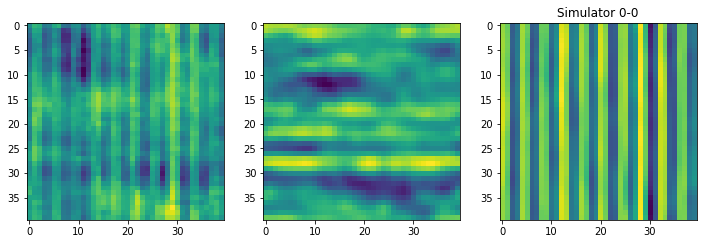

[output:1]

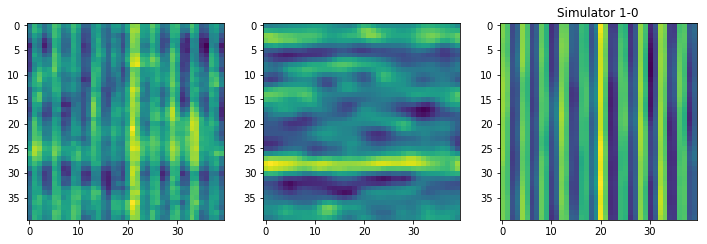

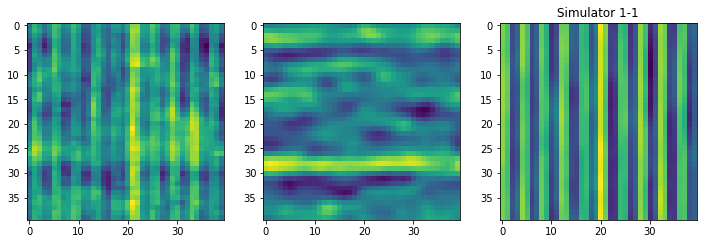

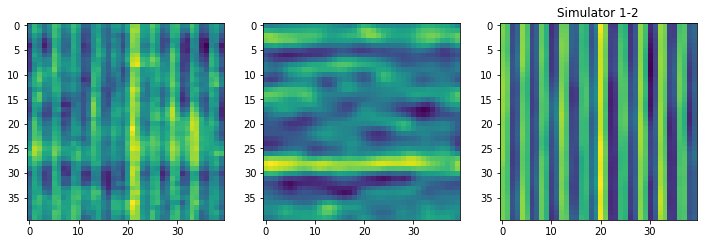

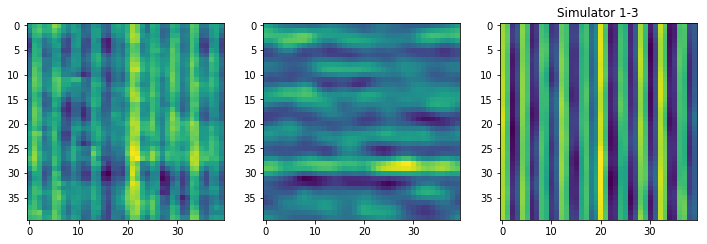

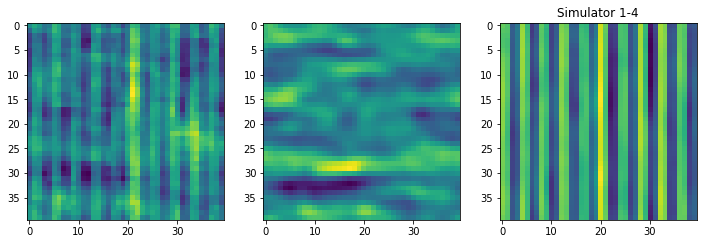

[output:2]

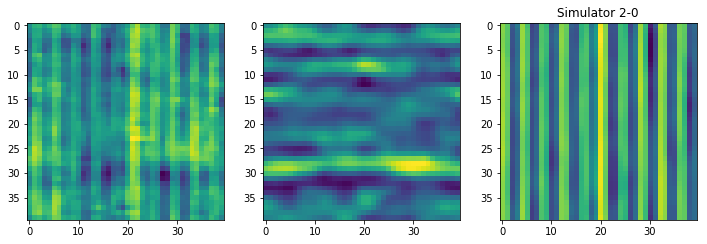

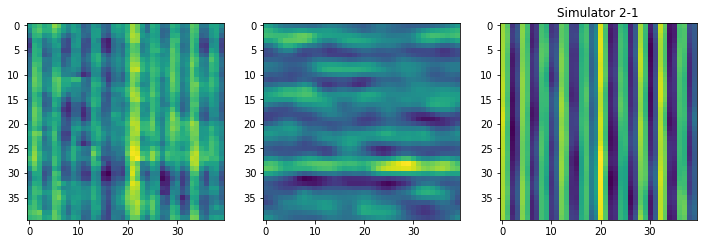

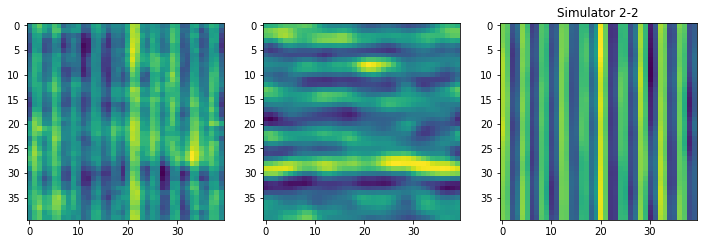

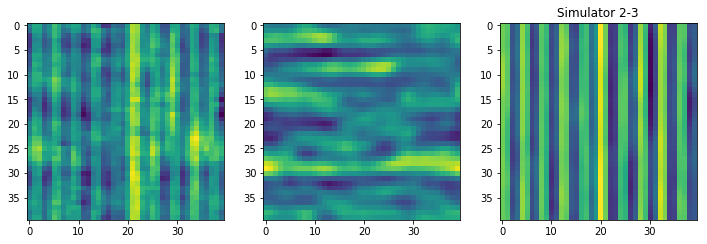

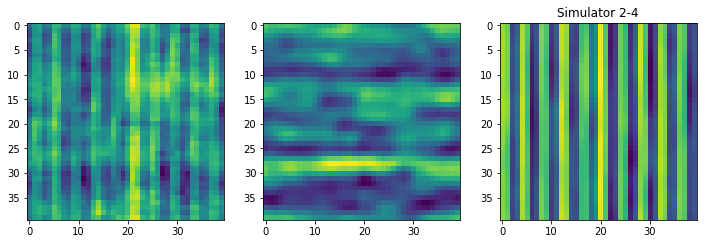

[output:3]

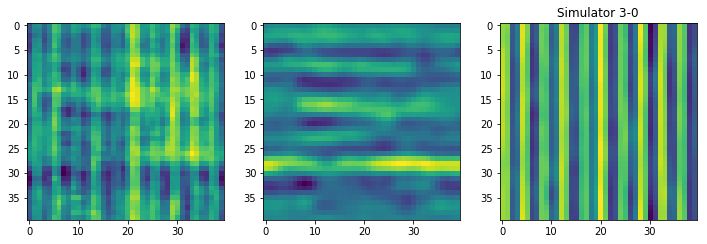

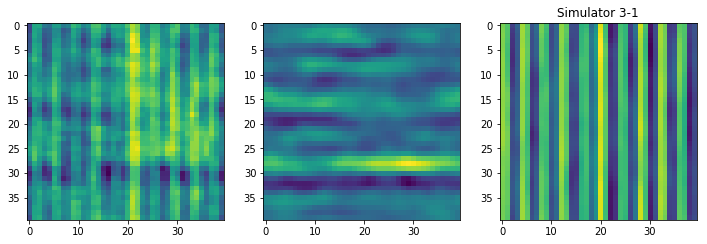

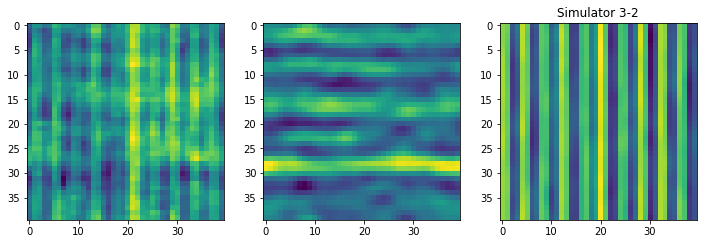

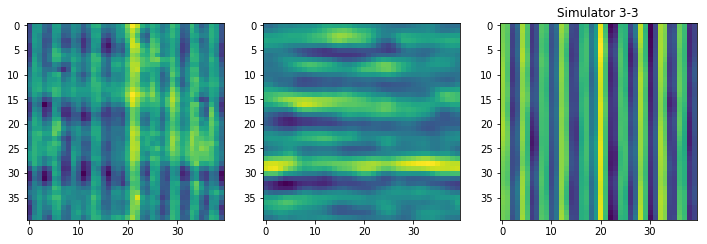

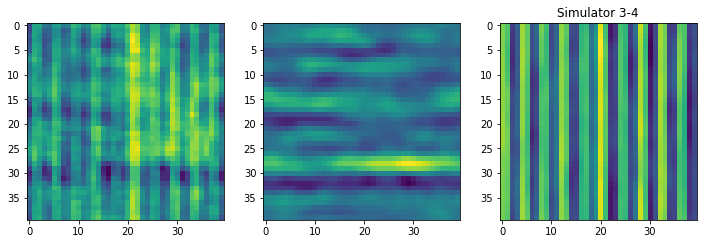

In [25]:
%%px


#Plot all particles on all nodes
for i, particle in enumerate(ensemble.particles):
    fig = plt.figure(figsize=(12, 8))
    eta, hu, hv = particle.download(interior_domain_only=True)
    plt.subplot(1,3,1)
    plt.imshow(eta)
    plt.subplot(1,3,2)
    plt.imshow(hu)
    plt.subplot(1,3,3)
    plt.imshow(hv)
    plt.title("Simulator " + str(MPI.COMM_WORLD.rank) + "-" + str(i))

In [15]:
def plotDistanceInfo(ensemble_info, title=None):
    # Only rank 0 creates a figure:
    fig = None
    plotRows = 2
    fig = plt.figure(figsize=(10, 6))
    gridspec.GridSpec(plotRows, 3)


    # PLOT DISCTRIBUTION OF PARTICLE DISTANCES AND THEORETIC OBSERVATION PDF
    ax0 = plt.subplot2grid((plotRows,3), (0,0), colspan=3)
    range_x = np.sqrt(ensemble_info['obs_var'])*20

    # With observation 
    x = np.linspace(0, range_x, num=100)
    plt.plot(x, ensemble_info['gauss_pdf'], 'g', label="pdf directly from innovations")
    plt.legend()
    plt.title("Distribution of particle innovations")

    #hisograms:
    ax1 = ax0.twinx()
    ax1.hist(ensemble_info['innovations'], bins=30, \
             range=(0, range_x),\
             normed=True, label="particle innovations (norm)")

    # PLOT SORTED DISTANCES FROM OBSERVATION
    ax0 = plt.subplot2grid((plotRows,3), (1,0), colspan=3)
    indices_sorted_by_observation = ensemble_info['innovations'].argsort()
    ax0.plot(ensemble_info['gauss_weights'][indices_sorted_by_observation]/np.max(ensemble_info['gauss_weights']),\
             'g', label="Weight directly from innovations")
    ax0.set_ylabel('Weights directly from innovations', color='g')
    ax0.grid()
    ax0.set_ylim(0,1.4)
    #plt.legend(loc=7)
    ax0.set_xlabel('Particle ID')

    ax1 = ax0.twinx()
    ax1.plot(ensemble_info['innovations'][indices_sorted_by_observation], label="innovations")
    ax1.set_ylabel('Innovations', color='b')

    plt.title("Sorted distances from observation")

    if title is not None:
        plt.suptitle(title, fontsize=16)
    #plt.tight_layout()

    return fig

# Main loop

In [16]:
#-------------------------------------------------------------------------------
# 4) Define observation times and run simulation
#    Here, we store a plot before and after each observation time step
#    in order to inspect the results.
#-------------------------------------------------------------------------------

#resampling_times = np.linspace(100, 500, 5)*sim_args['dt']
##resampling_times = [100*sim_args['dt']]
#print("Will resample at times: ", resampling_times)
#infoPlots = []
#
## Run particle filter:
#t = 0
#for i, resampling_time in enumerate(resampling_times):
#    #Runs each simulator sub_t seconds forward in time
#    #i.e., each particle runs one or more model steps
#    assimilation_dt = resampling_time - t
#    ensemble_stats = ensembleStep(ensemble, assimilation_dt)
#    t = resampling_time
#    
#    #Plot ensemble stats before resampling
#    if ensemble.rank == 0:
#        infoFig = plotDistanceInfo(ensemble_stats, title="i = " + str(i) + " before resampling")
#        plt.close(infoFig)
#        infoPlots.append(infoFig)
#
#    #Compute and plot ensemble stats after resampling
#    ensemble_stats = gatherEnsembleStatistics(ensemble)
#    if ensemble.rank == 0:
#        infoFig = plotDistanceInfo(ensemble_stats, title="t = " + str(i) + " post resampling")
#        plt.close(infoFig)
#        infoPlots.append(infoFig)
#    
#    print("{:03.0f}".format(100*i / len(resampling_times)) + " % => t=" + str(t), flush=True)
#
#print("Done")

In [17]:
# Inspect results
#def show_figures(figs):
#    for f in figs:
#        dummy = plt.figure()
#        new_manager = dummy.canvas.manager
#        new_manager.canvas.figure = f
#        f.set_canvas(new_manager.canvas)
#        filename= f._suptitle.get_text().replace(" ", "_").replace("=_", "") + ".png"
#        #plt.savefig(filename)
#
#if ensemble.rank == 0:
#    show_figures(infoPlots)